# **CPC353 Assignment 2**

## **This assignment is to classifying English-Malay sentences according to their semantics**

I used the GloVe 6B 100d pre-trained dwonloaded from [kaggle](https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt?resource=download) as the pre-trained embedding to embed the word vocabularies from the datasets given:


1.   `train.en` - training files of English Sentences
2.   `train.my` - training files of Malay Sentences
3. `train.cl` - training files of the classes
4. `test.en` - testing files of English Sentences
5. `test.my` - testing files of Malay Sentences
6. `test.cl` - testing files of the classes
7. `dev.en` - validating files of English Sentences
8. `dev.my` - validating files of Malay Sentences
9. `dev.cl` - validating files of the classes

There are 3 files for each training, testing and validation sets. The .en files are english sentences, the .my files are malay sentences, and the .cl files are the labels for english and malay files to indicate whether are both sentences similar. The .cl files are just 1s and 0s.

The notebook is sectioned into multiple steps: Tokenizing text, embedding text, building neural network, and testing the network.

### Neural network architecture
The neural network architecture starts with two models. One for the English language, one for the Malay language. After that, I will concatenate both models into one layer where it will perform binary classification.

### **Step 1: Reading the Text Files and Tokenizing the Texts**

I will first read the files into a list of sentences.

In [ ]:
def read_text(text_path):
    # This function will read the txt file and split the sentences with new line character, and will also remove the
    # last character since it is an empty string
    return open(text_path, "r", encoding="utf8").read().split("\n")[:-1]

train_text_en = read_text("/kaggle/input/english-malay/train.en")
train_text_my = read_text("/kaggle/input/english-malay/train.my")
train_label = read_text("/kaggle/input/english-malay/train.cl")

test_text_en = read_text("/kaggle/input/english-malay/test.en")
test_text_my = read_text("/kaggle/input/english-malay/test.my")
test_label = read_text("/kaggle/input/english-malay/test.cl")

dev_text_en = read_text("/kaggle/input/english-malay/dev.en")
dev_text_my = read_text("/kaggle/input/english-malay/dev.my")
dev_label = read_text("/kaggle/input/english-malay/dev.cl")

In [ ]:
# Defining all imports for the project
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Input, Concatenate
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import Model

Tokenization of text will be carried using the Tokenizer class from keras. Since I will be concatenating two models for two langauges. That means that I will have to tokenize both english and malay sentences separately.

In [ ]:
# Tokenize the text data
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(train_text_en)
en_sequences = en_tokenizer.texts_to_sequences(train_text_en)

my_tokenizer = Tokenizer()
my_tokenizer.fit_on_texts(train_text_my)
my_sequences = my_tokenizer.texts_to_sequences(train_text_my)

# Find the maximum length between the two sequences, so we can pad them
max_length = max(len(max(en_sequences, key=len)), len(max(my_sequences, key=len)))

# Padding the sequences to same length
en_sequences = pad_sequences(en_sequences, maxlen=max_length)
my_sequences = pad_sequences(my_sequences, maxlen=max_length)

In [ ]:
# Showing the number of vocabulary in both languages training data
# Uncomment for the tokens and sequences

print("Number of unique words in English text data: ", len(en_tokenizer.word_index))
# print("English text data is: ", en_tokenizer.word_index)
# print("English seqeunce: ", en_sequences)

print("Number of unique words in Malay text data: ", len(my_tokenizer.word_index))
# print("Malay text data is: ", my_tokenizer.word_index)
# print("Malay seqeunce: ", my_sequences)

Number of unique words in English text data:  39908
Number of unique words in Malay text data:  23279


### **Step 2: Embedding the Vocabulary**

The next step we will get our word embeddings of our dataset based on the pre-trained GloVe model.

In [ ]:
import numpy as np

# Helper function to embed the vocabularies
def vocab_embedding(filepath, word_index, embedding_dim):
  # Using the tokenizer word index attribute, we can determine the vocabulary size
  vocab_size = len(word_index) + 1
  embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim))

  with open(filepath) as f:
    for line in f:
      word, *vector = line.split()
      if word in word_index:
        idx = word_index[word]
        embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float)[:embedding_dim]

  return embedding_matrix_vocab

In [ ]:
en_embedding_matrix_vocab = vocab_embedding("/kaggle/input/glovedata/glove.6B.100d.txt", en_tokenizer.word_index, 100)
my_embedding_matrix_vocab = vocab_embedding("/kaggle/input/glovedata/glove.6B.100d.txt", my_tokenizer.word_index, 100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### **Step 3: Building the Neural Network**

I will be using a Long-Short Term Memory (LSTM) neural network for both languages.

Both LSTM neural network starts with an Input layer followed by an Embedding layer. After embedding, we will pass the network into a Dropout layer to avoid overfitting. After the network passes through the embedding layer, it will then enter the LSTM layer.

After the LSTM layer, both model for both languages will then be concatenated into two Dense layer. One with a activation function of Rectified Linear Unit (ReLU) and the second one, which is also the output layer with an activation function of Sigmoid for binary classification.

In [ ]:
english_input = Input(shape=(en_sequences.shape[1],))
malay_input = Input(shape=(my_sequences.shape[1],))

en_num_words = len(en_tokenizer.word_index) + 1
my_num_words = len(my_tokenizer.word_index) + 1

# Passing the inputs to the embedding layer
embedded_english = Embedding(
    input_dim = en_num_words,
    output_dim = 100,
    input_length = len(train_text_en),
    weights=[en_embedding_matrix_vocab]
)(english_input)

embedded_malay = Embedding(
    input_dim = my_num_words,
    output_dim = 100,
    input_length = len(train_text_my),
    weights=[my_embedding_matrix_vocab]
)(malay_input)

In [ ]:
en_dropout = Dropout(rate=0.2)(embedded_english)
my_dropout = Dropout(rate=0.2)(embedded_malay)

In [ ]:
# Pass embedded inputs to a LSTM layer
lstm = LSTM(100)
english_output = lstm(en_dropout)
malay_output = lstm(my_dropout)

lstm_concatenated = Concatenate()([english_output, malay_output])

In [ ]:
dense = Dense(64, activation='relu')(lstm_concatenated)
output = Dense(1, activation='sigmoid')(dense)

In [ ]:
model = Model(inputs=[english_input, malay_input], outputs=output)

# Compile the whole model.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_callback = [
    ModelCheckpoint("/kaggle/working/best_model")
]

In [ ]:
# Model training
history = model.fit([en_sequences, my_sequences],
                    np.array(train_label).astype(int), epochs=10, batch_size=32,
                   validation_split=0.2, callbacks=model_callback)

Epoch 1/10
3750/3750 [==============================] - 122s 32ms/step - loss: 0.3646 - accuracy: 0.8317 - val_loss: 0.3194 - val_accuracy: 0.8633
Epoch 2/10
3750/3750 [==============================] - 119s 32ms/step - loss: 0.1873 - accuracy: 0.9283 - val_loss: 0.3343 - val_accuracy: 0.8647
Epoch 3/10
3750/3750 [==============================] - 118s 31ms/step - loss: 0.1142 - accuracy: 0.9591 - val_loss: 0.3691 - val_accuracy: 0.8630
Epoch 4/10
3750/3750 [==============================] - 116s 31ms/step - loss: 0.0740 - accuracy: 0.9733 - val_loss: 0.3775 - val_accuracy: 0.8764
Epoch 5/10
3750/3750 [==============================] - 117s 31ms/step - loss: 0.0481 - accuracy: 0.9829 - val_loss: 0.4363 - val_accuracy: 0.8748
Epoch 6/10
3750/3750 [==============================] - 116s 31ms/step - loss: 0.0327 - accuracy: 0.9889 - val_loss: 0.6055 - val_accuracy: 0.8570
Epoch 7/10
3750/3750 [==============================] - 116s 31ms/step - loss: 0.0245 - accuracy: 0.9915 - val_loss: 0

### **Step 4: Visualizing the Model Accuracy and Loss**

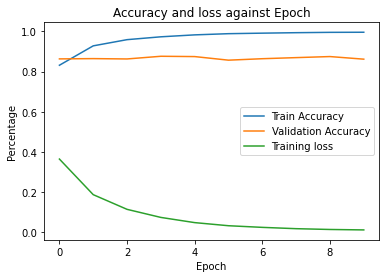

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.title("Accuracy and loss against Epoch")
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Training loss'])
plt.show()

### **Step 5: Testing the Model on the Test Dataset**

We will perform the same tokenization process as the training data. Then using `model.evaluate()`, we can see the model's accuracy and loss on the testing data.

In [ ]:
test_en_tokenizer = Tokenizer()
test_en_tokenizer.fit_on_texts(test_text_en)
test_en_sequences = en_tokenizer.texts_to_sequences(test_text_en)

test_my_tokenizer = Tokenizer()
test_my_tokenizer.fit_on_texts(test_text_my)
test_my_sequences = my_tokenizer.texts_to_sequences(test_text_my)

# Find the maximum length between the two sequences, so we can pad them
max_length = max(len(max(en_sequences, key=len)), len(max(my_sequences, key=len)))

# Padding the sequences to same length
test_en_sequences = pad_sequences(test_en_sequences, maxlen=max_length)
test_my_sequences = pad_sequences(test_my_sequences, maxlen=max_length)

In [ ]:
score = model.evaluate([test_en_sequences, test_my_sequences], np.array(test_label).astype(int))

1250/1250 [==============================] - 15s 11ms/step - loss: 1.0511 - accuracy: 0.8204


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0511388778686523
Test accuracy: 0.8203999996185303
